In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from aggmap import AggMap, AggMapNet

/home/shenwanxiang/anaconda3/envs/molmap/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shenwanxiang/anaconda3/envs/molmap/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shenwanxiang/anaconda3/envs/molmap/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/s

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() #

In [ ]:
_, w, h = x_train.shape
orignal_cols = ['p-%s' % str((i+1)).zfill(len(str(w*h))) for i in range(w*h)]
x_train_df = pd.DataFrame(x_train.reshape(x_train.shape[0], w*h), columns = orignal_cols)
x_test_df = pd.DataFrame(x_test.reshape(x_test.shape[0], w*h), columns = orignal_cols)

In [4]:
shuffled_cols = shuffle(orignal_cols, random_state=888)
x_train_df_shuffled = x_train_df[shuffled_cols]
x_test_df_shuffled = x_test_df[shuffled_cols]

## Step2: AggMap pre-fitting on training set

In [5]:
mp = AggMap(x_train_df_shuffled, metric='correlation')
mp = mp.fit(cluster_channels=1, var_thr=0, verbose=0, fmap_shape = (w, h)) 

2021-11-05 09:05:55,882 - INFO - [bidd-aggmap] - Calculating distance ...
2021-11-05 09:05:55,911 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 784/784 [00:01<00:00, 423.13it/s]


2021-11-05 09:07:00,843 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2021-11-05 09:07:06,099 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2021-11-05 09:07:06,803 - INFO - [bidd-aggmap] - Finished


## Step3: AggMap transformation on training and test test

In [6]:
X = mp.batch_transform(x_train_df_shuffled.values)
testX = mp.batch_transform(x_test_df_shuffled.values)

100%|##########| 10000/10000 [00:03<00:00, 2680.23it/s]


In [7]:
Y = pd.get_dummies(pd.Series(y_train)).values
testY = pd.get_dummies(pd.Series(y_test)).values
trainX, validX, trainY, validY = train_test_split(X, Y, test_size = 0.1, random_state = 888)

#select 10 samples for each class
gidx = pd.DataFrame(y_test).groupby(0).apply(lambda x:x.index.tolist()).apply(lambda x:x[:10]) 
gidx

0
0           [3, 10, 13, 25, 28, 55, 69, 71, 101, 126]
1              [2, 5, 14, 29, 31, 37, 39, 40, 46, 57]
2           [1, 35, 38, 43, 47, 72, 77, 82, 106, 119]
3            [18, 30, 32, 44, 51, 63, 68, 76, 87, 90]
4              [4, 6, 19, 24, 27, 33, 42, 48, 49, 56]
5          [8, 15, 23, 45, 52, 53, 59, 102, 120, 127]
6            [11, 21, 22, 50, 54, 66, 81, 88, 91, 98]
7             [0, 17, 26, 34, 36, 41, 60, 64, 70, 75]
8    [61, 84, 110, 128, 134, 146, 177, 179, 181, 184]
9              [7, 9, 12, 16, 20, 58, 62, 73, 78, 92]
dtype: object

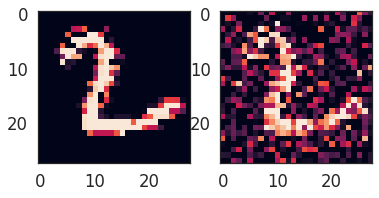

In [21]:
def gauss_noisy(X, c = 0.36):
    ''' 
    X: 4D array, n,w,h,c
    '''
    np.random.seed(123)
    X = np.clip(X + np.random.normal(size = X.shape, scale = c), 0, 1) 
    return X
sigma = 0.36
testX = testX.reshape(-1, mp.fmap_shape[0], mp.fmap_shape[1], 1)
testX_noisy = gauss_noisy(testX, c = sigma)

fig, axes = plt.subplots(ncols=2)
ax1, ax2 = axes
ax1.imshow(testX[1].reshape(*mp.fmap_shape))
ax2.imshow(testX_noisy[1].reshape(*mp.fmap_shape))

## Step4: Training AggMapNet

In [28]:
clf = AggMapNet.MultiClassEstimator(epochs = 80,  batch_size = 64, verbose=1,
                                    conv1_kernel_size = 3, dense_layers = [128, 64], 
                                    lr = 0.0001,  gpuid=0,)
clf.fit(trainX, trainY, validX, validY)

epoch: 0001, loss: 0.5866 - val_loss: 0.1580; accuracy: 0.9907 - val_accuracy: 0.9916                                                                                                    
epoch: 0002, loss: 0.1316 - val_loss: 0.0950; accuracy: 0.9941 - val_accuracy: 0.9947                                                                                                    
epoch: 0003, loss: 0.0927 - val_loss: 0.0963; accuracy: 0.9943 - val_accuracy: 0.9943                                                                                                    
epoch: 0004, loss: 0.0777 - val_loss: 0.0701; accuracy: 0.9958 - val_accuracy: 0.9959                                                                                                    
epoch: 0005, loss: 0.0641 - val_loss: 0.0777; accuracy: 0.9954 - val_accuracy: 0.9954                                                                                                    
epoch: 0006, loss: 0.0562 - val_loss: 0.0607; accuracy: 0.9968 - val_a

MultiClassEstimator(batch_norm=False, batch_size=64, conv1_kernel_size=3,
                    dense_avf='relu', dense_layers=[128, 64], dropout=0.0,
                    epochs=80, gpuid='0', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001,
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=1)

In [29]:
from scipy.stats import pearsonr
from skimage.metrics import structural_similarity as ssim
import seaborn as sns
sns.set(font_scale=1.5, style='white')
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
def _hm(IMP, ax, cmap = 'rainbow',):
    PCM = ax.imshow(IMP, cmap = cmap, vmin=0)
    ax.set_xticks([]) 
    ax.set_yticks([])
    clb = plt.colorbar(PCM, ax = ax, shrink = 0.7, pad = 0.04,  orientation = 'horizontal') #format = '%.2f'

## Nosiey-free, local

100%|##########| 1/1 [00:00<00:00,  4.01it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 632.05it/s]

100%|##########| 1/1 [00:00<00:00, 1471.17it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 1557.48it/s]

100%|##########| 1/1 [00:00<00:00, 1017.29it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 1407.96it/s]

100%|##########| 1/1 [00:00<00:00, 787.07it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 715.63it/s]

100%|##########| 1/1 [00:00<00:00, 1115.21it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 1031.05it/s]

100%|##########| 1/1 [00:00<00:00, 98.84it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 1404.66it/s]

100%|##########| 1/1 [00:00<00:00, 940.85it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 143.55it/s]

100%|##########| 1/1 [00:00<00:00, 1117.59it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 624.06it/s]

100%|##########| 1/1 [00:00<00:00, 1173.56it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 633.29it/s]

100%|##########| 1/1 [00:00<00:00, 1526.87it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 571.82it/s]

100%|##########| 2306/2306 [00:00<00:00, 2704.87it/s]


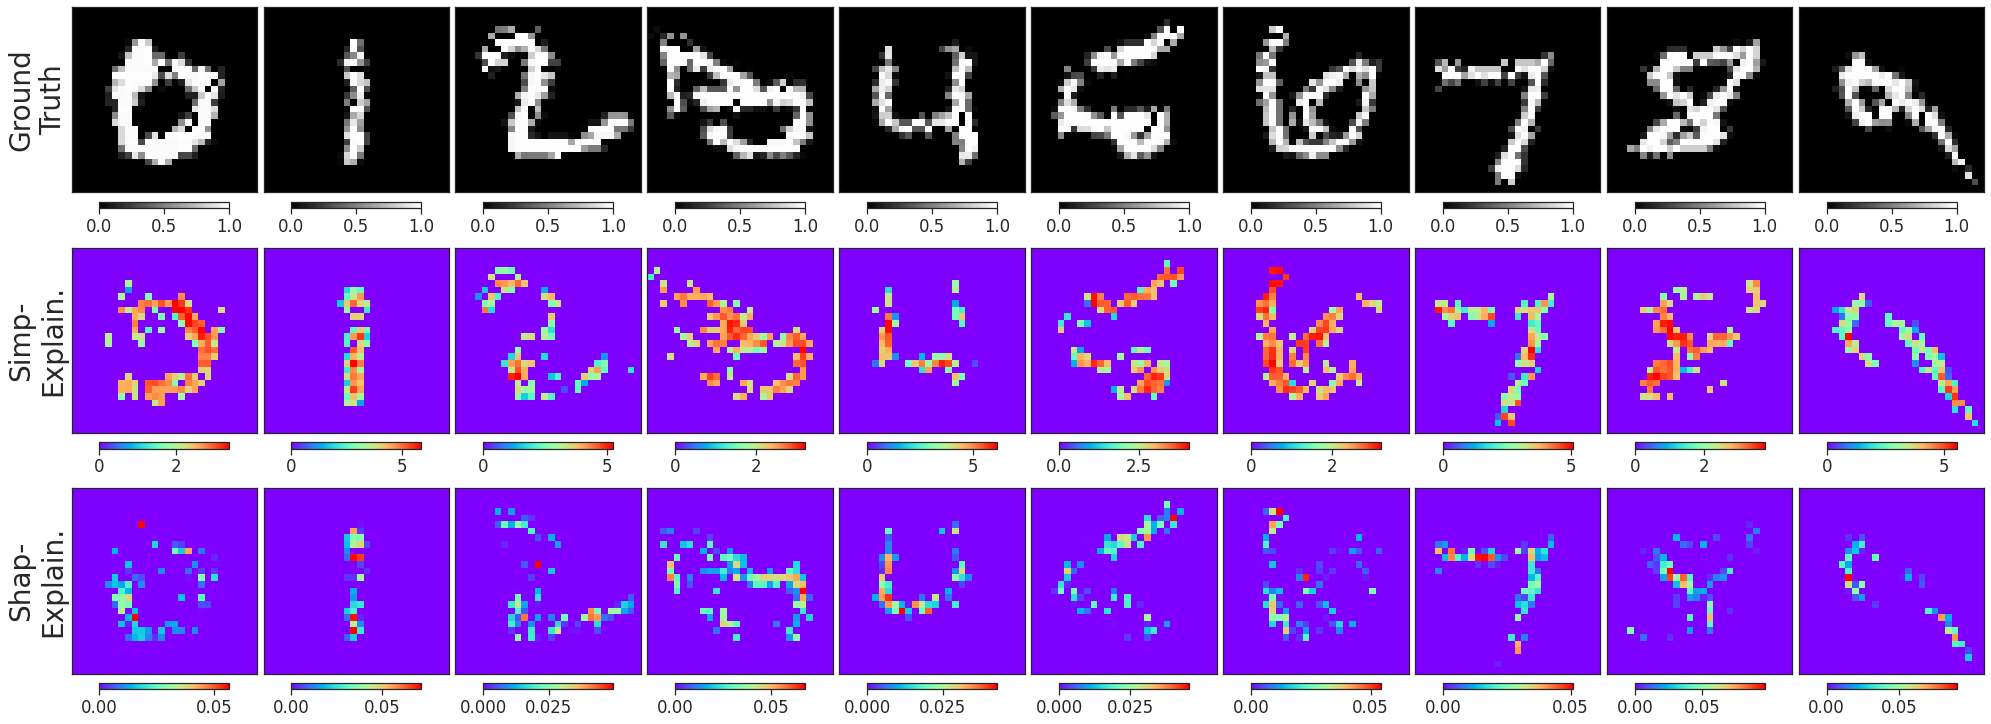

In [30]:
fig, axes = plt.subplots(nrows= 3, ncols= 10, figsize=(28, 10.5), sharex = False, sharey = False, gridspec_kw={'height_ratios': [1.4, 1.4, 1.4]})

pcc_ssim = []

for l, i in gidx.apply(lambda x:x[0]).items():

    ax1, ax2, ax3 = axes[:, l]
    
    simp_explainer = AggMapNet.simply_explainer(clf, mp, apply_logrithm=True)
    I1 = simp_explainer.local_explain(testX[[i]], testY[[i]])
    IMP = I1.simply_importance.values.reshape(*mp.fmap_shape)
    IMP[IMP < 0.5] = 0 # smaller than 0 is 0 for simply


    shap_explainer = AggMapNet.shapley_explainer(clf, mp)
    I2 = shap_explainer.local_explain(testX[[i]])
    IMP2 = I2['shapley_importance_class_%s' % l].values.reshape(*mp.fmap_shape)

    
    tr = testX[i].reshape(*mp.fmap_shape)
    
    S1 = ssim(tr / tr.max(), IMP/IMP.max(), full=True)
    S2 = ssim(tr / tr.max(), IMP2/IMP2.max(), full=True) #the full structural similarity image

    df1 = pd.Series(S1[1].reshape(w*h, )).to_frame(name = 'SSIM to Groudtruth')
    df1['data'] = 'Simp-Explain.'


    df2 = pd.Series(S2[1].reshape(w*h, )).to_frame(name = 'SSIM to Groudtruth')
    df2['data'] = 'Shap-Explain.'

    df = df1.append(df2)

    p1, v1 = pearsonr(tr.reshape(w*h,), IMP.reshape(w*h,))
    p2, v2 = pearsonr(tr.reshape(w*h,), IMP2.reshape(w*h,))

    _hm(tr, ax=ax1, cmap = 'gray',)
    _hm(IMP, ax=ax2, cmap = 'rainbow',)    
    _hm(IMP2, ax=ax3, cmap = 'rainbow',)

    if l == 0:
        ax1.set_ylabel('Ground\nTruth', fontdict={'fontsize':28})
        ax2.set_ylabel('Simp-\nExplain.', fontdict={'fontsize':28})
        ax3.set_ylabel('Shap-\nExplain.', fontdict={'fontsize':28})
        #ax4.set_ylabel('SSIM to GroudTruth')
    plt.tight_layout()

    pcc_ssim.append([l, p1, p2, S1[0], S2[0]])
    
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.035, hspace=None)
fig.savefig('./free-local.pdf', bbox_inches='tight', dpi=400) 

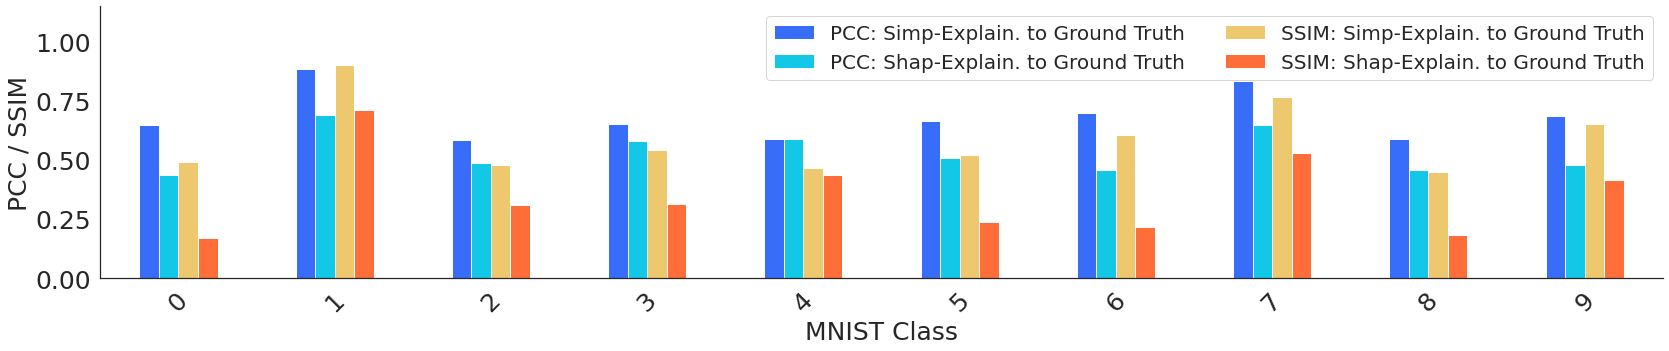

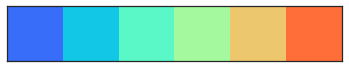

In [31]:
fig, ax = plt.subplots(figsize=(28, 5))

c = sns.color_palette('rainbow', 6)
sns.palplot(c)

dfpcc = pd.DataFrame(pcc_ssim).set_index(0)
dfpcc.index = dfpcc.index.astype(str)
dfpcc.columns = ['PCC: Simp-Explain. to Ground Truth',  
                 'PCC: Shap-Explain. to Ground Truth', 
                 'SSIM: Simp-Explain. to Ground Truth', 
                 'SSIM: Shap-Explain. to Ground Truth', ]

dfpcc.plot(kind='bar',ax=ax, color = [c[0], c[1], c[-2], c[-1]], )
ax.set_ylim(0,1.15)
ax.legend(fontsize=20, ncol=2)

ax.set_xlabel('MNIST Class', fontsize=25)
ax.set_ylabel('PCC / SSIM', fontsize=25)

ax.tick_params(axis='x', rotation=45, labelsize=25)
ax.tick_params(axis='y', rotation=0, labelsize=25)

sns.despine(ax = ax, top=True, right=True, left=False, bottom=False)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.035, hspace=None)

fig.savefig('./free-local-PCC-SSIM.pdf', bbox_inches='tight', dpi=400) 

In [38]:
c = c.as_hex()
[c[0], c[1], c[-2], c[-1]]

['#386df9', '#12c8e6', '#ecc86f', '#ff6d38']

## Nosiey-added 0.36, local

100%|##########| 1/1 [00:00<00:00, 1003.90it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 898.91it/s]

100%|##########| 1/1 [00:00<00:00, 956.95it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 614.46it/s]

100%|##########| 1/1 [00:00<00:00, 1172.25it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 843.58it/s]

100%|##########| 1/1 [00:00<00:00, 1528.54it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 974.29it/s]

100%|##########| 1/1 [00:00<00:00, 1580.97it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 886.75it/s]

100%|##########| 1/1 [00:00<00:00, 1463.47it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 999.36it/s]

100%|##########| 1/1 [00:00<00:00, 1106.09it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 597.82it/s]

100%|##########| 1/1 [00:00<00:00, 1317.31it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 1055.97it/s]

100%|##########| 1/1 [00:00<00:00, 972.25it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 1650.00it/s]

100%|##########| 1/1 [00:00<00:00, 1186.17it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 673.03it/s]

100%|##########| 2846/2846 [00:01<00:00, 2652.33it/s]


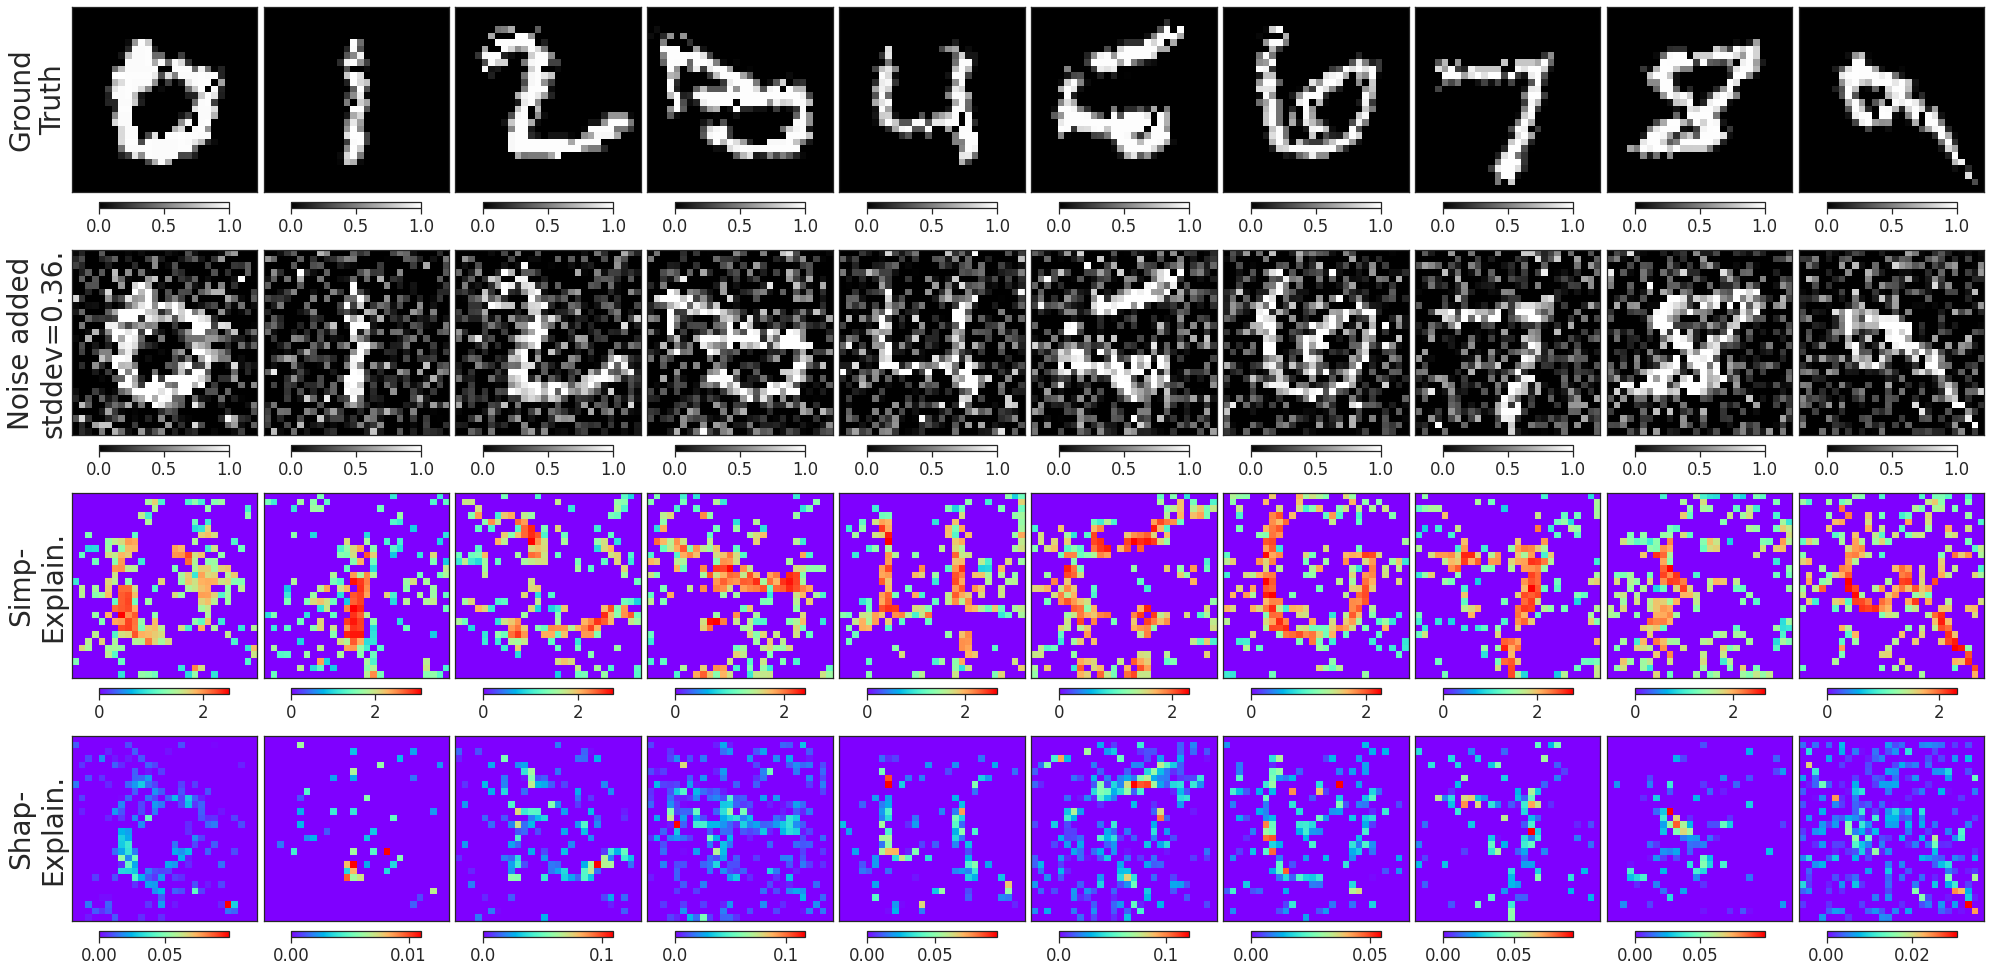

In [32]:
fig, axes = plt.subplots(nrows= 4, ncols= 10, figsize=(28, 14), sharex = False, sharey = False, gridspec_kw={'height_ratios': [1.4, 1.4, 1.4,1.4]})

pcc_ssim = []

for l, i in gidx.apply(lambda x:x[0]).items():

    ax1, ax2, ax3, ax4 = axes[:, l]
    
    simp_explainer = AggMapNet.simply_explainer(clf, mp, apply_logrithm=True)
    I1 = simp_explainer.local_explain(testX_noisy[[i]], testY[[i]])
    IMP = I1.simply_importance.values.reshape(*mp.fmap_shape)
    IMP[IMP < 0.8] = 0 # smaller than 0 is 0 for simply


    shap_explainer = AggMapNet.shapley_explainer(clf, mp)
    I2 = shap_explainer.local_explain(testX_noisy[[i]])
    IMP2 = I2['shapley_importance_class_%s' % l].values.reshape(*mp.fmap_shape)

    
    tr = testX[i].reshape(*mp.fmap_shape)
    tr_n = testX_noisy[i].reshape(*mp.fmap_shape)
    
    S1 = ssim(tr / tr.max(), IMP/IMP.max(), full=True)
    S2 = ssim(tr / tr.max(), IMP2/IMP2.max(), full=True) #the full structural similarity image

    df1 = pd.Series(S1[1].reshape(w*h, )).to_frame(name = 'SSIM to Groudtruth')
    df1['data'] = 'Simp-Explain.'


    df2 = pd.Series(S2[1].reshape(w*h, )).to_frame(name = 'SSIM to Groudtruth')
    df2['data'] = 'Shap-Explain.'

    df = df1.append(df2)

    p1, v1 = pearsonr(tr.reshape(w*h,), IMP.reshape(w*h,))
    p2, v2 = pearsonr(tr.reshape(w*h,), IMP2.reshape(w*h,))

    _hm(tr, ax=ax1, cmap = 'gray',)
    _hm(tr_n, ax=ax2, cmap = 'gray',)    
    _hm(IMP, ax=ax3, cmap = 'rainbow',)    
    _hm(IMP2, ax=ax4, cmap = 'rainbow',)

    if l == 0:
        ax1.set_ylabel('Ground\nTruth', fontdict={'fontsize':28})
        ax2.set_ylabel('Noise added\nstddev=0.36.', fontdict={'fontsize':28})
        ax3.set_ylabel('Simp-\nExplain.', fontdict={'fontsize':28})
        ax4.set_ylabel('Shap-\nExplain.', fontdict={'fontsize':28})
        #ax4.set_ylabel('SSIM to GroudTruth')
    plt.tight_layout()

    pcc_ssim.append([l, p1, p2, S1[0], S2[0]])
    
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.035, hspace=None)
fig.savefig('./noisy-local.pdf', bbox_inches='tight', dpi=400) 

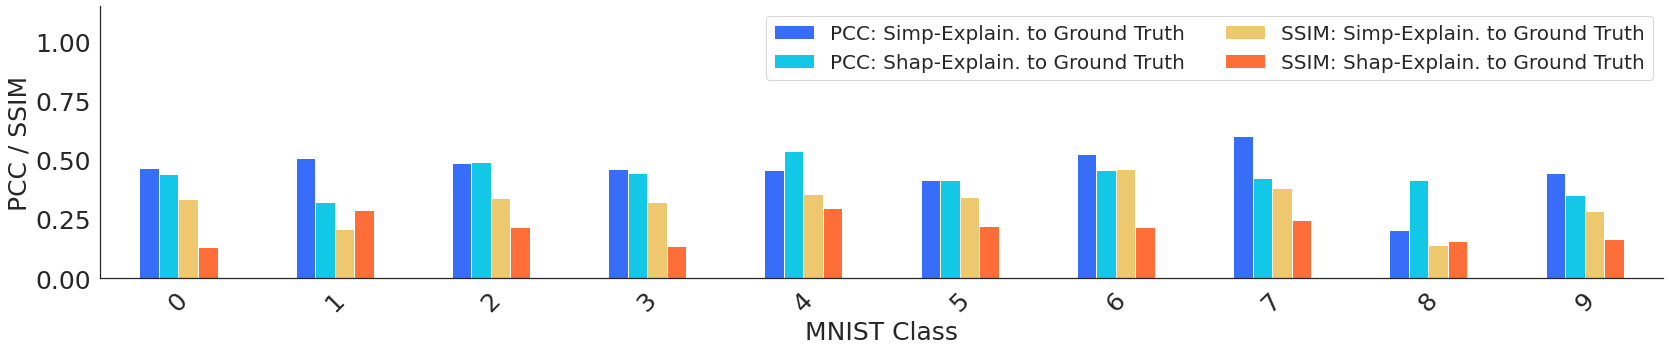

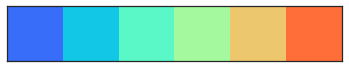

In [33]:
fig, ax = plt.subplots(figsize=(28, 5))

c = sns.color_palette('rainbow', 6)
sns.palplot(c)

dfpcc = pd.DataFrame(pcc_ssim).set_index(0)
dfpcc.index = dfpcc.index.astype(str)
dfpcc.columns = ['PCC: Simp-Explain. to Ground Truth',  
                 'PCC: Shap-Explain. to Ground Truth', 
                 'SSIM: Simp-Explain. to Ground Truth', 
                 'SSIM: Shap-Explain. to Ground Truth', ]

dfpcc.plot(kind='bar',ax=ax, color = [c[0], c[1], c[-2], c[-1]], )
ax.set_ylim(0,1.15)
ax.legend(fontsize=20, ncol=2)

ax.set_xlabel('MNIST Class', fontsize=25)
ax.set_ylabel('PCC / SSIM', fontsize=25)

ax.tick_params(axis='x', rotation=45, labelsize=25)
ax.tick_params(axis='y', rotation=0, labelsize=25)

sns.despine(ax = ax, top=True, right=True, left=False, bottom=False)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.035, hspace=None)

fig.savefig('./noisy-local-PCC-SSIM.pdf', bbox_inches='tight', dpi=400) 

## Nosiey-free, global

In [47]:
gidx = pd.DataFrame(y_test).groupby(0).apply(lambda x:x.index.tolist()).apply(lambda x:x[:8]) 
select = list(chain(*gidx.tolist()))

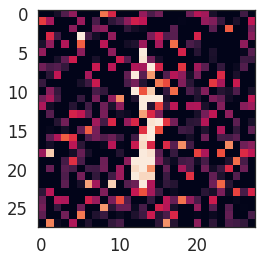

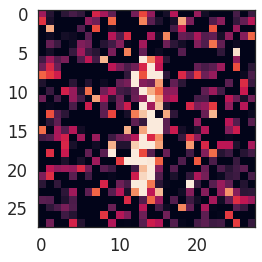

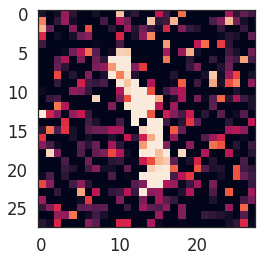

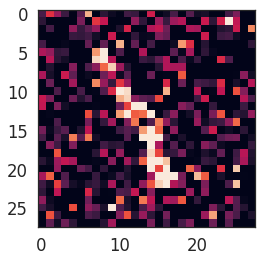

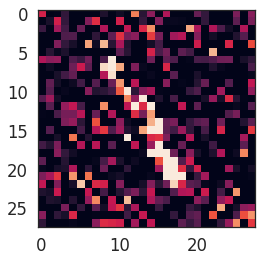

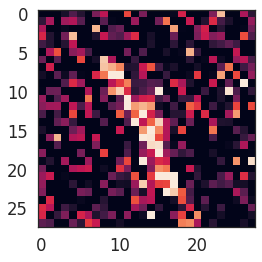

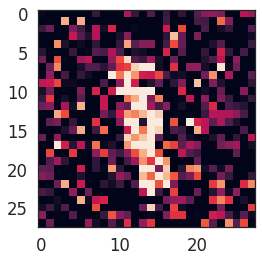

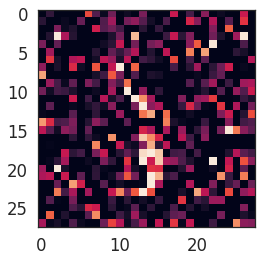

In [56]:
for i in gidx.iloc[1]:
    fig, ax = plt.subplots()
    ax.imshow(testX_noisy[i].reshape(28,28))

In [49]:
from itertools import chain
simp_explainer = AggMapNet.simply_explainer(clf, mp, apply_logrithm=False)
SIMP_g = simp_explainer.global_explain(testX_noisy[select], testY[select])

2021-10-07 11:42:04,785 - INFO - [bidd-aggmap] - calculating feature importance for class 0 ...


100%|##########| 784/784 [00:06<00:00, 125.95it/s]


2021-10-07 11:42:11,016 - INFO - [bidd-aggmap] - calculating feature importance for class 1 ...


100%|##########| 784/784 [00:06<00:00, 125.36it/s]


2021-10-07 11:42:17,276 - INFO - [bidd-aggmap] - calculating feature importance for class 2 ...


100%|##########| 784/784 [00:06<00:00, 124.91it/s]


2021-10-07 11:42:23,559 - INFO - [bidd-aggmap] - calculating feature importance for class 3 ...


100%|##########| 784/784 [00:06<00:00, 125.94it/s]


2021-10-07 11:42:29,791 - INFO - [bidd-aggmap] - calculating feature importance for class 4 ...


100%|##########| 784/784 [00:06<00:00, 127.35it/s]


2021-10-07 11:42:35,954 - INFO - [bidd-aggmap] - calculating feature importance for class 5 ...


100%|##########| 784/784 [00:06<00:00, 124.43it/s]


2021-10-07 11:42:42,261 - INFO - [bidd-aggmap] - calculating feature importance for class 6 ...


100%|##########| 784/784 [00:06<00:00, 126.14it/s]


2021-10-07 11:42:48,482 - INFO - [bidd-aggmap] - calculating feature importance for class 7 ...


100%|##########| 784/784 [00:06<00:00, 123.59it/s]


2021-10-07 11:42:54,833 - INFO - [bidd-aggmap] - calculating feature importance for class 8 ...


100%|##########| 784/784 [00:06<00:00, 117.15it/s]


2021-10-07 11:43:01,531 - INFO - [bidd-aggmap] - calculating feature importance for class 9 ...


100%|##########| 784/784 [00:06<00:00, 125.21it/s]


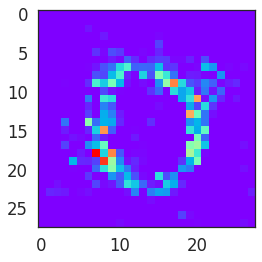

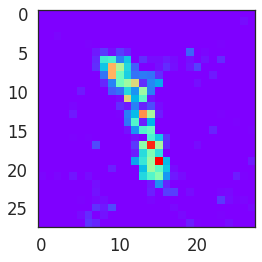

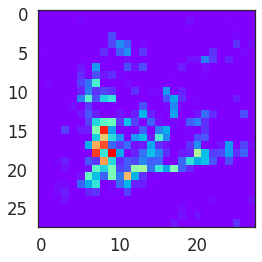

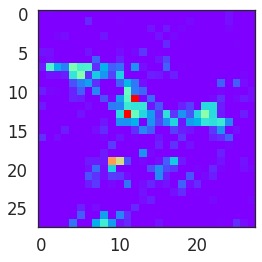

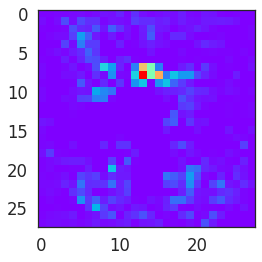

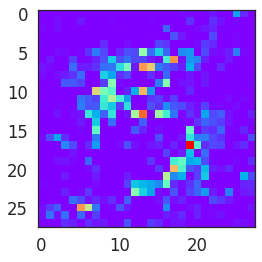

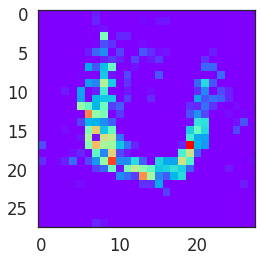

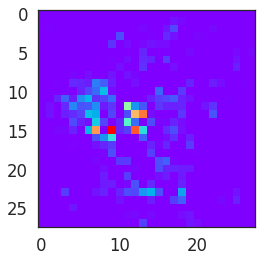

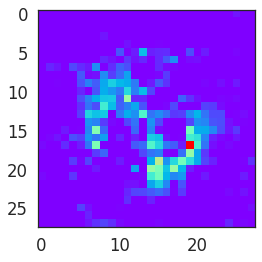

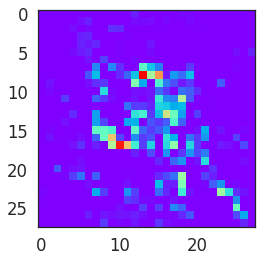

In [50]:
for x in range(10):
    g = SIMP_g['simply_importance_class_%s' % x].values.reshape(*mp.fmap_shape)
    fig, ax = plt.subplots()
    ax.imshow(g, cmap = 'rainbow', vmin=0)

In [51]:
shap_explainer = AggMapNet.shapley_explainer(clf, mp)
SHAP_g = shap_explainer.global_explain(testX_noisy[select])

100%|##########| 1/1 [00:00<00:00,  3.79it/s]


  0%|          | 0/80 [00:00<?, ?it/s]


100%|##########| 1/1 [00:00<00:00, 1389.76it/s]

100%|##########| 2926/2926 [00:01<00:00, 1617.43it/s]

100%|##########| 1/1 [00:00<00:00, 161.36it/s]

100%|##########| 2908/2908 [00:01<00:00, 2820.72it/s]

100%|##########| 1/1 [00:00<00:00, 198.42it/s]

100%|##########| 2944/2944 [00:01<00:00, 2784.06it/s]

100%|##########| 1/1 [00:00<00:00, 201.13it/s]

100%|##########| 2966/2966 [00:01<00:00, 2912.51it/s]

100%|##########| 1/1 [00:00<00:00, 195.02it/s]

100%|##########| 2908/2908 [00:00<00:00, 3150.69it/s]

100%|##########| 1/1 [00:00<00:00, 205.62it/s]

100%|##########| 2906/2906 [00:00<00:00, 3130.04it/s]

100%|##########| 1/1 [00:00<00:00, 196.33it/s]

100%|##########| 2914/2914 [00:01<00:00, 2855.99it/s]

100%|##########| 1/1 [00:00<00:00, 133.85it/s]

100%|##########| 2970/2970 [00:01<00:00, 2878.47it/s]

100%|##########| 1/1 [00:00<00:00, 2102.41it/s]

100%|##########| 2828/2828 [00:01<00:00, 2717.29it/s]

100%|##########| 1/1 [00:00<00:00, 1308.27it/s]

100%|##########| 2860

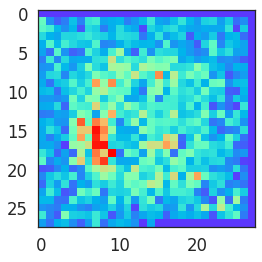

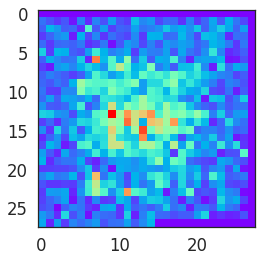

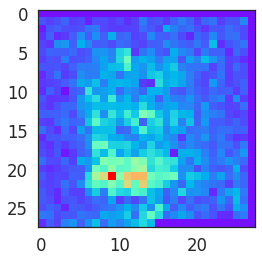

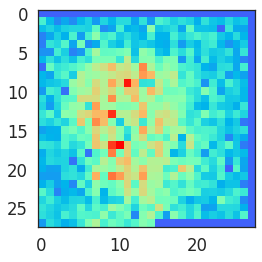

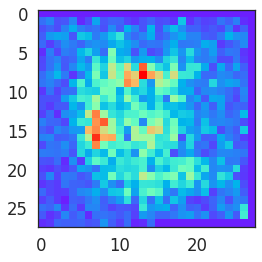

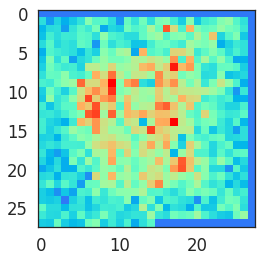

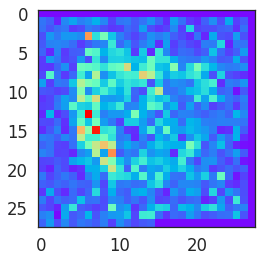

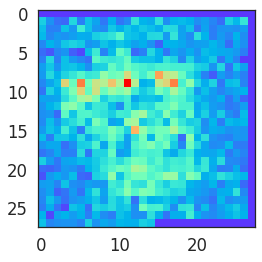

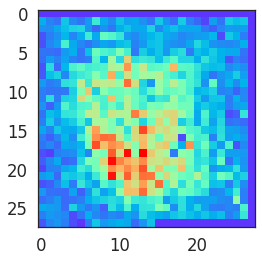

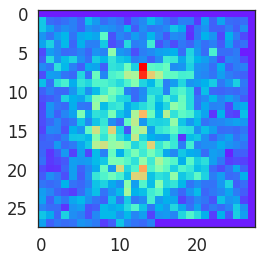

In [52]:
for x in range(10):
    s = SHAP_g['shapley_importance_class_%s' % x]
    smin = s[s != 0].min()
    s1 = s.values
    s1[s1 == 0] = smin
    g = s1.reshape(*mp.fmap_shape)
    fig, ax = plt.subplots()
    ax.imshow(g, cmap = 'rainbow', vmin=0)

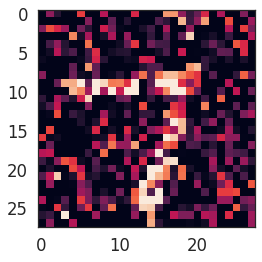

In [53]:
plt.imshow(testX_noisy[0].reshape(28,28))